## Trying out approximate Bayesian computation for a simple SOSP model

Based on Toni et al. (2009)

In [46]:
# Setting up
# Running the Monte-Carlo simulations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

centers = np.array([0, 1])
harmonies_true = np.array([1.0, 0.5])
gamma_true = 0.25
ndim = centers.size
D_true = 0.001  # Small noise
maxsteps = 1000
tau = 0.01  # time step size
xinit = 0.68  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True


def run(nruns, centers, harmonies, gamma, D):
    """Run the model many times"""
    maxsteps = 500
    data_list = []
    for run in range(nruns):
        xhist = np.zeros(maxsteps)
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                               + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append(['x0', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append(['x1', t])
        else:
            data_list.append(['Other', t])
    data = pd.concat([pd.DataFrame([i], columns=('Attractor', 'Time')) for i in data_list])
    return data

In [137]:
sample = run(100, centers, harmonies_true, gamma_true, D_true)
sample_counts = sample.groupby('Attractor', as_index=False).agg(['count']).values
sample_means = sample.groupby('Attractor', as_index=False).agg(['mean']).values
#print(sample_counts, sample_means)

In [138]:
posterior = []
for trial in range(5000):
    if trial % 500 == 0: print('Trial {}'.format(trial))
    h1_curr = np.random.uniform(0.25, 0.75)
    harmonies_curr = [1., h1_curr]
    gamma_curr = np.random.uniform(0.1, 0.5)
    D_curr = np.random.uniform(0., 0.25)
    curr = run(100, centers, harmonies_curr, gamma_curr, D_curr)
    curr_counts = curr.groupby('Attractor', as_index=False).agg(['count']).values
    curr_means = curr.groupby('Attractor', as_index=False).agg(['mean']).values
    if curr_counts.size > 2:
        curr_counts = curr_counts[1:]
        curr_means = curr_means[1:]
    sse = np.sqrt(np.sum((sample_means - curr_counts)**2) + np.sum((sample_means - curr_means)**2))
    if sse < 150:
        posterior.append([h1_curr, gamma_curr, D_curr])


Trial 0
Trial 500
Trial 1000
Trial 1500
Trial 2000
Trial 2500
Trial 3000
Trial 3500
Trial 4000
Trial 4500


/Users/garrettsmith/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


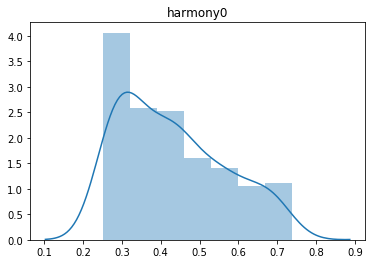

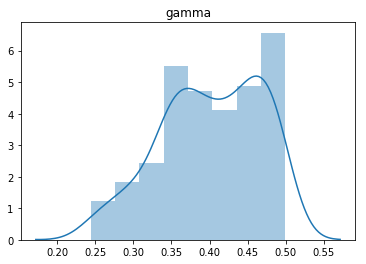

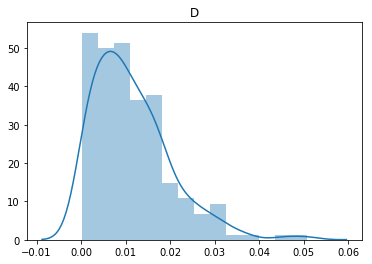

In [139]:
hpost = np.array([h[0] for h in posterior])
gpost = np.array([g[1] for g in posterior])
Dpost = np.array([d[2] for d in posterior])

post = [hpost, gpost, Dpost]
labels = ['harmony0', 'gamma', 'D']

import seaborn as sns
for i in range(3):
    sns.distplot(post[i])
    plt.title(labels[i])
    plt.show()

In [140]:
len(posterior)

205